In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import h5py
import os
from os import walk
import scipy.io as sio
import skimage.io as io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import pandas as pd
import glob, random
from sklearn.model_selection import train_test_split 
import cv2
import tqdm.notebook as tq
# import torchvision.transforms as transforms

In [ ]:
# import glob
# import os

# def change_ext(class_name):
#   os.mkdir('/content/drive/MyDrive/Dopnet_data/dummy_folder/'+class_name)
#   for i in glob.glob('/content/drive/MyDrive/Dopnet_data/'+class_name+'/*.png'):
#     f = i.split('/')[-1]
#     f = f.split('.')[0]
#     image = io.imread(i)
#     cv2.imwrite('/content/drive/MyDrive/Dopnet_data/dummy_folder/'+class_name+'/'+f+'.jpg', image)

# classes = ['Click', 'Pinch', 'Swipe', 'Wave']
# for i in classes:
#   change_ext(i)

In [ ]:
train_transform = T.Compose([
    T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    T.ToTensor(),
])

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
# test = sio.loadmat(os.path.realpath("/content/drive/MyDrive/Data_Per_PersonData_Training_Person_A.mat"))

Data_Training -> Doppler_Signals -> [0][0][0] (redundant) -> gesture information [0,...3], image number

0 gesture -> 56 images
1 gesture -> 98 images
2 gesture -> 64 images
3 gesture -> 105 images

In [ ]:
# gesture_info = {'Wave':0, 'Pinch':1, 'Swipe':2, 'Click':3}
# for k,i in gesture_info.items():
#   # os.mkdir('/content/drive/MyDrive/Dopnet_data/'+k)
#   for j in range(test['Data_Training']['Doppler_Signals'][0][0][0][i].shape[0]):
#     x = test['Data_Training']['Doppler_Signals'][0][0][0][i][j][0]
#     x=20*np.log10(abs(x)/np.amax(abs(x)))
#     fig = plt.imshow(x,vmin=-50, vmax=0,cmap='jet', aspect='auto',extent=[0,x.shape[1],-501,500]) 
#     plt.axis('off')
#     fig.axes.get_xaxis().set_visible(False)
#     fig.axes.get_yaxis().set_visible(False)
#     plt.savefig('/content/drive/MyDrive/Dopnet_data/'+k+'/%d' %j, bbox_inches='tight', pad_inches=0)

In [ ]:
# def create_negative_images(folder_name):
#   l = ['Click', 'Pinch', 'Swipe', 'Wave']
#   l.remove(folder_name)
#   negative_list = []
#   for i in l:
#     negative_list += [i for i in glob.glob('/content/drive/MyDrive/Dopnet_data/'+i+'/*.png')]
#   random.shuffle(negative_list)
#   return negative_list

# def create_df(folder_name, negative_images):
#   tmp = [i for i in glob.glob('/content/drive/MyDrive/Dopnet_data/'+folder_name+'/*.png')]
#   return pd.DataFrame({'anchor': tmp,
#               'positive': random.sample(tmp, len(tmp)),
#               'negative': negative_images[:len(tmp)]})

In [ ]:
# l = ['Click', 'Pinch', 'Swipe', 'Wave']
# final_df = pd.DataFrame({'anchor': pd.Series(dtype='str'),
#                    'positive': pd.Series(dtype='str'),
#                    'negative': pd.Series(dtype='str')})
# for i in l:
#   negative = create_negative_images(i)
#   df = create_df(i,negative)
#   final_df = pd.concat([final_df, df], ignore_index=True)
# final_df = final_df.sample(frac=1).reset_index(drop=True)
# final_df.to_csv('/content/drive/MyDrive/Dopnet_data/data.csv')

In [ ]:
final_df = pd.read_csv('/content/drive/MyDrive/Dopnet_data/data.csv', index_col=0)
final_df

,anchor,positive,negative
0,/content/drive/MyDrive/Dopnet_data/Wave/36.png,/content/drive/MyDrive/Dopnet_data/Wave/13.png,/content/drive/MyDrive/Dopnet_data/Click/79.png
1,/content/drive/MyDrive/Dopnet_data/Pinch/6.png,/content/drive/MyDrive/Dopnet_data/Pinch/46.png,/content/drive/MyDrive/Dopnet_data/Click/103.png
2,/content/drive/MyDrive/Dopnet_data/Wave/39.png,/content/drive/MyDrive/Dopnet_data/Wave/54.png,/content/drive/MyDrive/Dopnet_data/Swipe/16.png
3,/content/drive/MyDrive/Dopnet_data/Swipe/33.png,/content/drive/MyDrive/Dopnet_data/Swipe/39.png,/content/drive/MyDrive/Dopnet_data/Click/96.png
4,/content/drive/MyDrive/Dopnet_data/Click/101.png,/content/drive/MyDrive/Dopnet_data/Click/103.png,/content/drive/MyDrive/Dopnet_data/Wave/21.png
...,...,...,...
318,/content/drive/MyDrive/Dopnet_data/Click/7.png,/content/drive/MyDrive/Dopnet_data/Click/35.png,/content/drive/MyDrive/Dopnet_data/Swipe/63.png
319,/content/drive/MyDrive/Dopnet_data/Swipe/23.png,/content/drive/MyDrive/Dopnet_data/Swipe/55.png,/content/drive/MyDrive/Dopnet_data/Pinch/37.png
320,/content/drive/MyDrive/Dopnet_data/Pinch/80.png,/content/drive/MyDrive/Dopnet_data/Pinch/24.png,/content/drive/MyDrive/Dopnet_data/Wave/28.png
321,/content/drive/MyDrive/Dopnet_data/Pinch/45.png,/content/drive/MyDrive/Dopnet_data/Pinch/50.png,/content/drive/MyDrive/Dopnet_data/Wave/11.png


In [ ]:
train_df, valid_df = train_test_split(final_df, test_size=0.2, random_state=42)

In [ ]:
class DopNet_data(Dataset):
  def __init__(self,df):
    self.df = df
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    anchor = cv2.cvtColor(io.imread(row.anchor), cv2.COLOR_RGBA2RGB)
    positive = cv2.cvtColor(io.imread(row.positive), cv2.COLOR_RGBA2RGB)
    negative = cv2.cvtColor(io.imread(row.negative), cv2.COLOR_RGBA2RGB)

    anchor = torch.from_numpy(anchor).permute(2,0,1) / 255.0
    positive = torch.from_numpy(positive).permute(2,0,1) / 255.0
    negative = torch.from_numpy(negative).permute(2,0,1) / 255.0
    return anchor, positive, negative

In [ ]:
trainset = DopNet_data(train_df)
validset = DopNet_data(valid_df)

print(len(trainset))
print(len(validset))

258
65


In [ ]:
train_loader = DataLoader(trainset, batch_size=16, shuffle=True)
valid_loader = DataLoader(validset, batch_size=16, shuffle=True)

In [ ]:
!nvidia-smi

Fri Dec  9 18:26:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    39W /  70W |   3790MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# device = 'cuda:0'

torch.Size([3, 480, 620]) torch.Size([3, 480, 620]) torch.Size([3, 480, 620])


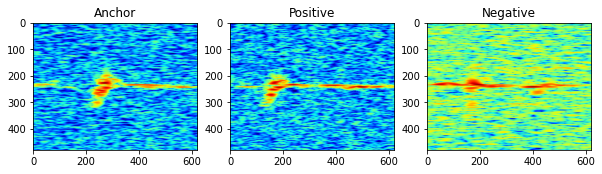

In [ ]:
idx = 60
A,P,N = validset[idx]

print(A.shape, P.shape, N.shape)

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #Conv2d(in_channels,out_channel,kernel_size)
        self.conv1 = nn.Conv2d(3,64,4, stride=1)
        self.conv2 = nn.Conv2d(64,128,4, stride=2)
        self.conv3 = nn.Conv2d(128,128,3, stride=2)
        self.conv4 = nn.Conv2d(128,256,2, stride=2)
        self.conv5 = nn.Conv2d(256,512,2, stride=2)
        self.conv6 = nn.Conv2d(512,1024,2, stride=2)

        #BatchNorm 
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(1024)

        #Fully connected layers
        self.fc1 = nn.Linear(1024*1*2,1024)
        self.fcout = nn.Linear(1024,256)

    def pooling_activation_fn_layer(self,x):

        #1,105,105
        x = F.relu(self.bn1(self.conv1(x)))
        #64,96,96
        x = F.max_pool2d(x,(2,2))
        #64,48,48
        x = F.relu(self.bn2(self.conv2(x)))
        #128,42,42
        x = F.max_pool2d(x,(2,2))
        #128,21,21
        x = F.relu(self.bn3(self.conv3(x)))
        #128,18,18
        x = F.max_pool2d(x,(2,2))
        #128,9,9
        x = F.relu(self.bn4(self.conv4(x)))
        #256,6,6
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        return x

    def forward(self,x):
        x = self.pooling_activation_fn_layer(x)
        x = x.view(-1,x.shape[1]*x.shape[2]*x.shape[3])
        x = self.fc1(x)
        x = self.fcout(x)
        return x

vanilla_siamese = Net()


In [ ]:
# Move model to device
# device = 'cpu'
vanilla_siamese = vanilla_siamese.to(device)

# Count the trainable parameters of the model
# def count_parameters(model):
#     num_of_params = sum(i.numel() for i in model.parameters() if i.requires_grad)
#     print(f'The model architecture:\n\n', model)
#     print(f'\nThe model has {num_of_params:,} trainable parameters')
    
# count_parameters(vanilla_siamese)

In [ ]:
summary(vanilla_siamese, (3,480, 620))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 477, 617]           3,136
       BatchNorm2d-2         [-1, 64, 477, 617]             128
            Conv2d-3        [-1, 128, 118, 153]         131,200
       BatchNorm2d-4        [-1, 128, 118, 153]             256
            Conv2d-5          [-1, 128, 29, 37]         147,584
       BatchNorm2d-6          [-1, 128, 29, 37]             256
            Conv2d-7            [-1, 256, 7, 9]         131,328
       BatchNorm2d-8            [-1, 256, 7, 9]             512
            Conv2d-9            [-1, 512, 3, 4]         524,800
      BatchNorm2d-10            [-1, 512, 3, 4]           1,024
           Conv2d-11           [-1, 1024, 1, 2]       2,098,176
      BatchNorm2d-12           [-1, 1024, 1, 2]           2,048
           Linear-13                 [-1, 1024]       2,098,176
           Linear-14                  [

In [ ]:
# saving and loading model
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

# def load_checkpoint(model, optimizer):
#     save_path = f'siameseNet-batchnorm50.pt'
#     state_dict = torch.load(save_path)
#     model.load_state_dict(state_dict['model_state_dict'])
#     optimizer.load_state_dict(state_dict['optimizer_state_dict'])
#     val_loss = state_dict['val_loss']
#     print(f'Model loaded from <== {save_path}')
    
#     return val_loss

In [ ]:
class ModifiedTripletLoss(nn.Module):
  
  def __init__(self, loss_type, margin=1.0):
    self.margin = margin
    self.loss_type = loss_type
    super(ModifiedTripletLoss, self).__init__()

  def normalize(self,vector):
    return F.normalize(vector, p=2.0, dim = 0)

  def Cosine(self, x1, x2):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    output = cos(x1,x2)
    return output.mean()
    # return output.mean()
    # dot_product = torch.dot(x1,x2).to(device)
    # denominator = (torch.linalg.norm(x1) * torch.linalg.norm(x2)).to(device)
    # return (dot_product/denominator)

  def Theta(self, x1, x2):
    return torch.arccos(self.Cosine(x1, x2)) + torch.deg2rad(torch.Tensor([10])).to(device)

  def Triangle_Similarity(self, x1, x2):
    # theta = torch.deg2rad(self.Theta(x1, x2)).to(device)
    theta = self.Theta(x1, x2).to(device)
    return (torch.dot(self.normalize(torch.linalg.norm(x1, dim=1)),self.normalize(torch.linalg.norm(x2, dim=1)))*torch.sin(theta))/2

  def Sector_Similarity(self, x1, x2):

    def Euclidian(x1,x2):
      pdist = torch.nn.PairwiseDistance(p=2)
      eu = pdist(x1, x2)
      return eu
      # return torch.linalg.norm(x1-x2, dim=1)

    def Magnitude_diff(x1,x2):
      return torch.abs(self.normalize(torch.linalg.norm(x1, dim=1)) - self.normalize(torch.linalg.norm(x2, dim=1)))

    ED = Euclidian(x1, x2)
    MD = Magnitude_diff(x1, x2)
    theta = self.Theta(x1, x2)
    
    return torch.pi * (ED+MD)**2 * torch.rad2deg(theta)/360
    
  def TSSS(self, x1, x2):
    return self.Triangle_Similarity(x1,x2) * self.Sector_Similarity(x1,x2)
  
  def forward(self,anchor, positive, negative):
    
    if self.loss_type == 'TSSS':
      positive_sim = self.TSSS(anchor, positive)
      print(positive_sim)
      exit()
      negative_sim_a = self.TSSS(anchor, negative)
      negative_sim_b = self.TSSS(positive, negative)
    if self.loss_type =='Cosine':
      positive_sim = self.Cosine(anchor, positive)
      negative_sim_a = self.Cosine(anchor, negative)
      negative_sim_b = self.Cosine(positive, negative)
    if self.loss_type =='TS':
      positive_sim = self.Triangle_Similarity(anchor, positive)
      negative_sim_a = self.Triangle_Similarity(anchor, negative)
      negative_sim_b = self.Triangle_Similarity(positive, negative)


    # return positive_sim, negative_sim_a, negative_sim_b

    loss = torch.relu(positive_sim - (negative_sim_a + negative_sim_b)/2.0 + self.margin)
    return loss.mean()

In [ ]:
import torch.optim as optim

loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)
#loss_fn = ModifiedTripletLoss(loss_type='Cosine')
# loss_fn = nn.TripletMarginWithDistanceLoss(distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y))
optimizer = optim.SGD(vanilla_siamese.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_siamese(model,trainset, validset,num_epochs,loss_fn):
  best_val_loss = float('Inf')
  train_losses=[]
  val_losses=[]
  current_step= 0
  for i in range(num_epochs):
    current_train_loss=0.0
    model.train()
    print("Epoch %d"%(i+1))
    for anc,pos,neg in tq.tqdm(train_loader):

      anc = anc.to(device)
      pos = pos.to(device)
      neg = neg.to(device)
      anc_emb = model(anc)
      pos_emb = model(pos)
      neg_emb = model(neg)
      triplet_loss = loss_fn(anc_emb, pos_emb, neg_emb)

      #Backprop
      optimizer.zero_grad()
      triplet_loss.backward()
      optimizer.step()
      current_train_loss+=triplet_loss.item()

    #Calculate training loss
    average_training_loss = current_train_loss/len(trainset)
    train_losses.append(average_training_loss)

    current_val_loss = 0.0
    with torch.no_grad():

      model.eval()
      for anc,pos,neg in valid_loader:
            anc = anc.to(device)
            pos = pos.to(device)
            neg = neg.to(device)
            anc_emb = model(anc)
            pos_emb = model(pos)
            neg_emb = model(neg)
            triplet_loss = loss_fn(anc_emb, pos_emb, neg_emb)
            current_val_loss += triplet_loss.item()

    average_validation_loss =  current_val_loss/ len(validset)
    val_losses.append(average_validation_loss)
    print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'.format(i+1, num_epochs, average_training_loss, average_validation_loss))
    # if average_validation_loss < best_val_loss:
    #   best_val_loss = average_validation_loss
    #   save_name = '/content/drive/MyDrive/Dopnet_data/checkpoints_TSSS/best_model_{}.pt'.format(i+1)
    #   save_checkpoint(save_name, model, optimizer, best_val_loss)
  return train_losses, val_losses
  

In [ ]:
train_losses, val_losses = train_siamese(vanilla_siamese,trainset,validset,10,loss_fn)

Epoch 1


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [1/10],Train Loss: 0.0459, Valid Loss: 0.03604892
Epoch 2


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [2/10],Train Loss: 0.0119, Valid Loss: 0.01337406
Epoch 3


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [3/10],Train Loss: 0.0025, Valid Loss: 0.01135886
Epoch 4


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [4/10],Train Loss: 0.0031, Valid Loss: 0.00771003
Epoch 5


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [5/10],Train Loss: 0.0056, Valid Loss: 0.00695297
Epoch 6


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [6/10],Train Loss: 0.0017, Valid Loss: 0.00621975
Epoch 7


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [7/10],Train Loss: 0.0006, Valid Loss: 0.00416224
Epoch 8


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [8/10],Train Loss: 0.0003, Valid Loss: 0.00293422
Epoch 9


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [9/10],Train Loss: 0.0013, Valid Loss: 0.00439904
Epoch 10


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [10/10],Train Loss: 0.0001, Valid Loss: 0.00224625


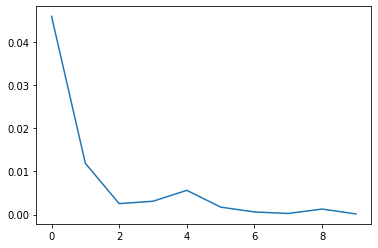

In [ ]:
plt.plot(train_losses)

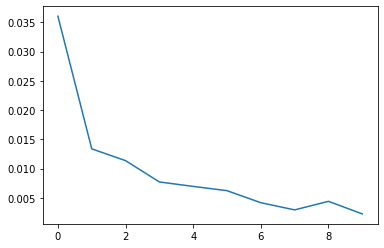

In [ ]:
plt.plot(val_losses)

In [ ]:
# !pip install torchviz
# from torchviz import make_dot
# x = torch.zeros(1, 3, 480, 620, dtype=torch.float, requires_grad=False)
# yhat = vanilla_siamese(x)
# make_dot(yhat, params=dict(list(vanilla_siamese.named_parameters()))).render("siamese_net", format="png")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'siamese_net.png'

In [ ]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_array = np.array(anc_img_names)
  encodings = []
  model.eval()
  with torch.no_grad():
    for i in tq.tqdm(anc_img_names_array):
      A = io.imread(i)
      A = cv2.cvtColor(A, cv2.COLOR_RGBA2RGB)
      A = torch.from_numpy(A).permute(2,0,1) / 255.0
      A = A.to(device)
      # A = A[-1,:]
      A_enc = model(A.unsqueeze(0))
      # if i==0:
      #   print(A_enc.shape)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis=1)

  return df_enc

In [ ]:
inference_model = vanilla_siamese.to(device)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/Dopnet_data/checkpoints_euclidian/best_model_12.pt',map_location=device)
inference_model.load_state_dict(checkpoint['model_state_dict'])
df_enc = get_encoding_csv(inference_model, final_df['anchor'])

  0%|          | 0/323 [00:00<?, ?it/s]

In [ ]:
df_enc.to_csv('/content/drive/MyDrive/Dopnet_data/database_euclidian.csv', index=False)
df_enc.head()

,anchor,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,/content/drive/MyDrive/Dopnet_data/Wave/36.png,-0.504671,0.225939,-0.672517,0.425705,0.348904,-0.462666,0.782222,0.345237,-0.091307,...,0.566718,-0.376045,-0.055014,-0.814117,0.478447,-0.596410,0.072178,0.165984,0.003707,-0.209259
1,/content/drive/MyDrive/Dopnet_data/Pinch/6.png,0.417555,-0.235252,-0.062345,-0.057520,-0.413167,-0.147986,-0.054206,-0.054027,0.160033,...,-0.357959,0.348521,-0.044694,-0.027340,-0.438402,0.152466,-0.063799,0.230874,0.068834,0.119001
2,/content/drive/MyDrive/Dopnet_data/Wave/39.png,-0.330549,0.372948,-0.220473,0.343052,0.414594,-0.400573,0.117804,0.103805,-0.051212,...,0.323510,-0.264635,-0.449902,-0.283937,0.404222,0.098039,0.106909,0.013501,-0.144312,-0.068768
3,/content/drive/MyDrive/Dopnet_data/Swipe/33.png,-0.014182,-0.399450,0.159966,0.396868,0.306437,-0.295865,-0.104039,-0.167494,0.516951,...,-0.152346,-0.397242,0.040844,0.041853,0.477096,0.518627,0.051801,0.002887,-0.007695,-0.058767
4,/content/drive/MyDrive/Dopnet_data/Click/101.png,0.396934,0.214161,-0.791240,0.101875,-0.631112,-0.531558,0.027384,-0.394361,0.486883,...,-0.469550,0.699827,0.351589,-0.239409,-0.246529,0.520703,0.882021,-0.043647,-0.235774,-0.108147


In [ ]:
def euclidian_distance(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
  return dist

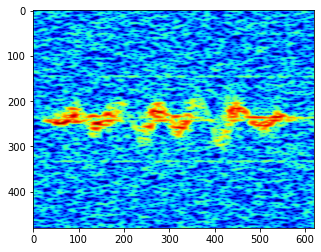

In [ ]:
idx = 70
img_name = df_enc['anchor'].iloc[idx]
# img_path = dataset_dir + img_name
img = io.imread(img_name)
plt.imshow(img)
plt.show()
img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
img = torch.from_numpy(img).permute(2,0,1) / 255.0

vanilla_siamese.eval()
with torch.no_grad():
  img = img.to(device)
  img_enc = vanilla_siamese(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [ ]:
distance = []
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['anchor']
for i in range(anc_enc_arr.shape[0]):
  dist = euclidian_distance(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)
closest_idx = np.argsort(distance)

In [ ]:
anc_img_names

## Save similar images utility for siamese network

In [ ]:
from IPython.utils.process import shutil
def save_images(img_name):
  save_dir = '/content/drive/MyDrive/Dopnet_data/inference_results/'+img_name.split('/')[-2]
  if os.path.exists(save_dir):
    pass
  else:
    os.mkdir(save_dir)
  shutil.copy(img_name,save_dir+'/'+img_name.split('/')[-1])
  closest = closest_idx[1:6]
  for i in closest:
    img_inf = df_enc['anchor'].iloc[i]
    shutil.copy(img_inf,save_dir+'/'+img_inf.split('/')[-1])
    # image = io.imread(img_inf)
    # plt.imshow(image)
    # plt.show()

save_images(img_name)

## Confusion Matrix

In [ ]:
dict_confusion = {'Pinch':{'Pinch':0, 'Click':0, 'Swipe':0, 'Wave':0},
                  'Click':{'Pinch':0, 'Click':0, 'Swipe':0, 'Wave':0},
                  'Swipe':{'Pinch':0, 'Click':0, 'Swipe':0, 'Wave':0},
                  'Wave':{'Pinch':0, 'Click':0, 'Swipe':0, 'Wave':0}}
for idx in range(len(df_enc['anchor'])):
  img_name = df_enc['anchor'].iloc[idx]
  #####################################
  anchor_class = img_name.split('/')[-2]
  #####################################
  img = io.imread(img_name)
  img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
  img = torch.from_numpy(img).permute(2,0,1) / 255.0
  #####################################
  inference_model.eval()
  with torch.no_grad():
    img = img.to(device)
    img_enc = inference_model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()
  #####################################
  distance = []
  anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
  for i in range(anc_enc_arr.shape[0]):
    dist = euclidian_distance(img_enc, anc_enc_arr[i : i+1, :])
    distance = np.append(distance, dist)
  closest_idx = np.argsort(distance)[1:6]
  for i in closest_idx:
    out_class = df_enc['anchor'].iloc[i].split('/')[-2]
    dict_confusion[anchor_class][out_class]+=1

{'Pinch': {'Pinch': 479, 'Click': 5, 'Swipe': 6, 'Wave': 0},
 'Click': {'Pinch': 15, 'Click': 510, 'Swipe': 0, 'Wave': 0},
 'Swipe': {'Pinch': 5, 'Click': 0, 'Swipe': 315, 'Wave': 0},
 'Wave': {'Pinch': 0, 'Click': 0, 'Swipe': 0, 'Wave': 280}}

In [ ]:
dict_confusion = {'Pinch': {'Pinch': 479, 'Click': 5, 'Swipe': 6, 'Wave': 0},
 'Click': {'Pinch': 15, 'Click': 510, 'Swipe': 0, 'Wave': 0},
 'Swipe': {'Pinch': 5, 'Click': 0, 'Swipe': 315, 'Wave': 0},
 'Wave': {'Pinch': 0, 'Click': 0, 'Swipe': 0, 'Wave': 280}}

In [ ]:
for i in dict_confusion.keys():
  total = sum(dict_confusion[i].values())
  for j in dict_confusion.keys():
    # print(dict_confusion[i][j])
    dict_confusion[i][j] = round(dict_confusion[i][j] / total,2)

In [ ]:
dict_confusion

{'Pinch': {'Pinch': 0.98, 'Click': 0.01, 'Swipe': 0.01, 'Wave': 0.0},
 'Click': {'Pinch': 0.03, 'Click': 0.97, 'Swipe': 0.0, 'Wave': 0.0},
 'Swipe': {'Pinch': 0.02, 'Click': 0.0, 'Swipe': 0.98, 'Wave': 0.0},
 'Wave': {'Pinch': 0.0, 'Click': 0.0, 'Swipe': 0.0, 'Wave': 1.0}}

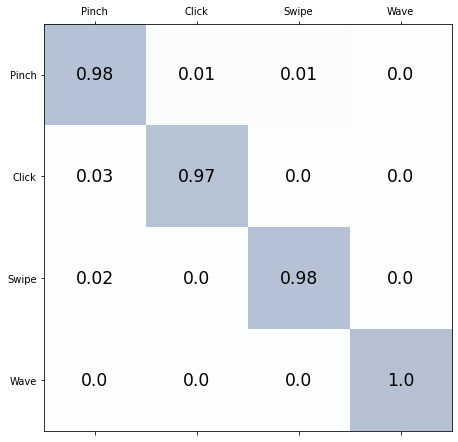

In [ ]:
tmp = list(dict_confusion.keys())
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(pd.DataFrame(dict_confusion), cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(tmp)):
  for j in range(len(tmp)):
    ax.text(x=j, y=i,s=round(dict_confusion[tmp[i]][tmp[j]],2), va='center', ha='center', size='xx-large')
plt.xticks([0,1,2,3], pd.DataFrame(dict_confusion).columns)
plt.yticks([0,1,2,3], pd.DataFrame(dict_confusion).index)
plt.show()

In [ ]:
def plot_confusion_matrix(dict_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)